# 크롤링 코드 1번코드

In [877]:
from selenium import webdriver

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver import Chrome, ChromeOptions
import requests
import lxml.html
import pandas as pd
import time
import random
import matplotlib.font_manager as fm
import numpy as np
from wordcloud import WordCloud

from kiwipiepy import Kiwi
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from gensim.matutils import Sparse2Corpus
import re
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
import warnings
import pyLDAvis.gensim
from sklearn.decomposition import TruncatedSVD #x를 분해 불필요한 부분을 자르는 svd 방법으로 
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
kiwi = Kiwi()
kiwi.prepare()

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()) # for Windows OS user

In [ ]:
#1-1번 크롤링 제품 정보 url로 받아오기
url='https://www.oliveyoung.co.kr/store/display/getMCategoryList.do?dispCatNo=1000001000100010001&fltDispCatNo=&prdSort=01&pageIdx=1&rowsPerPage=48&searchTypeSort=btn_thumb&plusButtonFlag=N&isLoginCnt=0&aShowCnt=0&bShowCnt=0&cShowCnt=0&trackingCd=Drawer_Cat1000001000100010001_Cat'
urls=[]
for page in range(1,3):
    res=requests.get(url.format(page))
    root=lxml.html.fromstring(res.text)
    links=root.cssselect('a.prd_thumb.goodsList')
    for link in links:
        urls.append(link.attrib['href'])

In [373]:
##1-2번코드 리뷰수 조정해서 크롤링
def move_next(browser):
    try:
        page_bar=browser.find_elements_by_css_selector('.pageing')[0]
        pages=page_bar.find_elements_by_css_selector('a')
        page_now=page_bar.find_elements_by_css_selector('strong')[0].text
    except IndexError as error:
        print("제품 리뷰가 없습니다")
        return True      
    for page in pages:
        page_num=page.text.strip()
        if page_num == '이전 10 페이지':
            pass
        elif page_num == '다음 10 페이지':
            page.send_keys('\n')
            time.sleep(2+random.uniform(0,1))
            return False
        elif int(page_num)>int(page_now):
            page.send_keys('\n')
            time.sleep(2+random.uniform(0,1))
            return False
        elif int(page_num)==3:
            break
    print('제품 데이터 수집 완료')
    return True

In [ ]:
#1-2번코드 모든 페이지 크롤링##
def move_next(browser):
    page_bar=browser.find_elements_by_css_selector('.pageing')[0]
    pages=page_bar.find_elements_by_css_selector('a')
    page_now=page_bar.find_elements_by_css_selector('strong')[0].text
    for page in pages:
        page_num=page.text.strip()
        if page_num == '이전 10 페이지':
            pass
        elif page_num == '다음 10 페이지':
            page.send_keys('\n')
            time.sleep(2+random.uniform(0,1))
            return False
        elif int(page_num)>int(page_now):
            page.send_keys('\n')
            time.sleep(2+random.uniform(0,1))
            return False
    print('마지막 페이지')
    return True

In [374]:
#1-3번 올리브영 크롤링 코드

tag=[]
text =[]
star = []
goods=[]

start = time.time()
for url in urls:
    browser=Chrome()
    browser.get(url)
    print('상품명',browser.find_elements_by_css_selector('.prd_name')[0].text,"수집 시작합니다.")
    time.sleep(3)
    browser.find_element_by_xpath('//*[@id="reviewInfo"]/a').click()
    time.sleep(2)
    is_done=False
    while(not is_done):
        cnt=0
        
        for gd in  range(10):
            gd=browser.find_elements_by_css_selector('.prd_name')[0]
            goods.append(gd.text)
            
        
        for tg in range(10):
            try:
                cv=browser.find_elements_by_css_selector('.user.clrfix')[tg]
                hi=cv.find_elements_by_css_selector('.tag')[0]
                tag.append(hi.text)
            except IndexError as error:
                tag.append("")


        for tx in range(0,10):
            try:
                cv=browser.find_elements_by_css_selector('.review_cont')[tx]
                hi=cv.find_elements_by_css_selector('.txt_inner')[0]
                text.append(hi.text)
            except IndexError as error:
                text.append("")

        for st in browser.find_elements_by_css_selector('.point'):
            if cnt==0:
                pass
            else:
                star.append(st.text)
            cnt += 1
        
        is_done=move_next(browser)
    print('상품명',browser.find_elements_by_css_selector('.prd_name')[0].text, '수집 완료했습니다!')
    print('소요시간:',round(time.time()-start),'초')
    print('리뷰갯수:',len(text),"개")
    print('—————————————————————')
    browser.quit()
        


상품명 메이크프렘 세이프미 릴리프 모이스처 클렌징폼 150ml 1+1 기획 수집 시작합니다.
제품 데이터 수집 완료
상품명 메이크프렘 세이프미 릴리프 모이스처 클렌징폼 150ml 1+1 기획 수집 완료했습니다!
소요시간: 18 초
리뷰갯수: 40 개
—————————————————————
상품명 [대용량] 라운드어라운드 그린티 약산성 클렌징폼 250ml 수집 시작합니다.


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=89.0.4389.128)


In [312]:
#쌓인 데이터 데이터 프레임으로 변환
tg_df=pd.DataFrame(tag)
text_df=pd.DataFrame(text)
star_df=pd.DataFrame(star)
goods_df=pd.DataFrame(goods)
df=pd.concat([goods_df,tg_df,text_df,star_df],axis=1)
df.columns=['제품명','피부타입','리뷰','별점']
df



,제품명,피부타입,리뷰,별점
0,메이크프렘 세이프미 릴리프 모이스처 클렌징폼 150ml 1+1 기획,건성\n웜톤\n각질\n탄력,👉🏻클렌징 대전 키트에서 사용해보고 바로 본품 구매했어요! 약산성이자 순한 폼클렌징...,5점만점에 5점
1,메이크프렘 세이프미 릴리프 모이스처 클렌징폼 150ml 1+1 기획,복합성\n봄웜톤\n각질\n모공,메이크프렘 세이프미 릴리피 모이스처 클렌징폼 4통째 사용하고 쓰는 찐 리뷰어입니다!...,5점만점에 5점
2,메이크프렘 세이프미 릴리프 모이스처 클렌징폼 150ml 1+1 기획,복합성\n쿨톤\n각질\n모공,"메이크프렘 세럼을 올영체험단으로 사용해보고\n제 피부에도 꽤 잘 맞고, 좋았어서\n...",5점만점에 5점
3,메이크프렘 세이프미 릴리프 모이스처 클렌징폼 150ml 1+1 기획,복합성\n웜톤\n모공\n민감성,사촌언니 집에서 써봤는데 대박!! \n순하고 넘 좋아서 구매했어요 ㅎㅎ\n클렌징 순...,5점만점에 5점
4,메이크프렘 세이프미 릴리프 모이스처 클렌징폼 150ml 1+1 기획,건성\n웜톤\n다크서클\n미백,5통째 사용하고 있는 폼클렌징이구요 저는 악건성이라서 건조함을 많이 느끼는 피부입니...,5점만점에 5점
...,...,...,...,...
56095,센카 퍼펙트 휩 페이셜 워시 120g,,항상 사용하는 제품으로 간단하게 클렌징하기 좋아요,NaN
56096,센카 퍼펙트 휩 페이셜 워시 120g,,센카 폼클랜징은 믿고 쓰는거죠! 화장 다 잘 지워져요,NaN
56097,센카 퍼펙트 휩 페이셜 워시 120g,,이거 클렌징은 말안해도 다들아시자나유?! 너무조아요 ㅎㅎㅎ,NaN
56098,센카 퍼펙트 휩 페이셜 워시 120g,건성,거품이 쫀쫀하게 잘나서 좋아요~ 세정력도 뛰어나요! 가끔 세일할때 득템하면 좋아요!,NaN


In [317]:
#데이터프레임 저장 
df.to_csv('74번째.csv')

# -------------------------------------------------------------------------------------------------------------

# 전처리 과정 2번코드

In [1263]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22365 entries, 0 to 25368
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   제품명     22365 non-null  object
 1   피부타입    2974 non-null   object
 2   리뷰      22365 non-null  object
 3   별점      22365 non-null  object
 4   label   22365 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [1258]:
df=pd.read_csv('로션.csv')

In [1172]:
df=pd.read_csv('스킨토너.csv')

In [1264]:
#2-3번 코드감정분석을 위한 라벨링
def star_score(starscore):
    good=['5점만점에 5점','5점만점에 4점']
    if starscore in good:
        return 1
    else:
        return 0

In [1260]:
#2-1번 df 데이터 전처리 코드
clean_df=df.dropna(subset=['별점'],how='any',axis=0)#크롤링 할때 , 마지막 페이지에 리뷰 데이터가 없을 경우 ''을 반환하기 때문에 null값이 생긴다.
clean_df.drop(['Unnamed: 0'],axis=1,inplace=True)#스킨토너 전처리
#clean_df.drop(['Unnamed: 0.1'],axis=1,inplace=True)#스킨토너 전처리
clean_df.drop(['Column1'],axis=1,inplace=True)#로션 전처리

#2-2번 
clean_df['리뷰'] = clean_df['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")#한글과 공백을 제외하고 모두 제거하는 정규 표현식 / 이모티콘,외국인이 쓴글들이 있음
clean_df['리뷰'] = clean_df['리뷰'].str.replace('^ +', "") # 외국인이 쓴 글 등 공백처리된 데이터를 empty value로 변경 
clean_df['리뷰'].replace('', np.nan, inplace=True) #공백을 nan값으로 변환
print(clean_df.isnull().sum())#null값 확인 
clean_df=clean_df.dropna(subset=['리뷰'],how='any',axis=0)#리뷰데이터의 null값 제거
print(clean_df.isnull().sum())

#2-3번 코드 갑정분석을 위한 긍 부정 라벨링
clean_df['label']=clean_df['별점'].apply(star_score)

제품명         0
피부타입    22110
리뷰       2855
별점          0
dtype: int64
제품명         0
피부타입    19391
리뷰          0
별점          0
dtype: int64


In [342]:
#2-4번코드
#한국 불용어 리스트 100개(일부 제외) + 데이터 분석후 불용어 제외 
stopwords = set(['뭐','호',"거", "것","저","때",'이거','수','데','감','히','후','이','있','하','것','들','그','되','이','보','않','없','나','사람','주','아니','등','같','우리','때','년','가','한','지','대하','오','말','일','그렇','위하','때문','그것','두','말하','알','그러나','받','못하','일'
,'그런','또','문제','더','사회','많','그리고','크','따르','나오','가지','씨','시키','만들','지금','생각하','그러','속','하나','집','살','모르','적','월','데','자신','안','어떤','내','경우'
,'명','생각','시간','그녀','다시','이런','앞','보이','번','나','다른','어떻','여자','개','전','들','사실','이렇','점','싶','말','정도','좀','원','잘','통하','소리','놓','에','저','분','중','듯','형','식','비','옆','돌','쟁','엄','남','요거','청','쪽','통','존','겹','조','광',])
#kiwi를 활용한 명사만 뽑으며 불용어 사전을 통해 불용어를 제거한 형태소 분석 코드
def extract_keywords(text):
    result=kiwi.analyze(text)
    for token, pos, start, end in result[0][0]:
        if pos[0] in 'N' and token not in stopwords:
            yield f'{token}/{pos}'

In [1178]:
#2-5번코드 최대한 많은 불필요한 단어 제거 
token_re = re.compile(r'\b\w{2,}\b', re.UNICODE) #양끝단사이에 2글자 이상있는것을 다뽑아라 영어 뿐만아니라 한국어도 가능 1글자짜리 무시하는것
def tokenizer(text):
    words=[]
    result=kiwi.analyze(text)
    for token,pos,start,end in result[0][0]:
        if pos[0] in 'N' and token not in stopwords:
            for word in token_re.findall(token):
                words.append(word)
    return words
            

In [1406]:
#2-6번코드 감정분석시 랜덤한 긍정라벨 뽑기
random_data=clean_df.sample(frac=1).reset_index(drop=True)

In [1407]:
random_data.label.value_counts()

1    21008
0     1357
Name: label, dtype: int64

In [1408]:
##감정분석시 이용
one_label=random_data[random_data['label']==1][:3150]
zero_label=random_data[random_data['label']==0]
gamjung=pd.concat([one_label,zero_label],axis=0)

In [1373]:
gamjung['label'].value_counts()

1    3150
0    1357
Name: label, dtype: int64

# TFIDF 3번코드

In [ ]:
##tfidf 이용 단어빈도 분석(클렌징폼)(tokenizer)
tfidf=TfidfVectorizer(max_features=1400,tokenizer=tokenizer)
tdm2=tfidf.fit_transform(clean_df['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [394]:
##tfidf 이용 단어빈도 분석(클렌징폼)1
tfidf=TfidfVectorizer(max_features=1500,tokenizer=extract_keywords)
tdm=tfidf.fit_transform(clean_df['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [1265]:
##tfidf 이용 단어빈도 분석(로션)(tokenizer)
tfidf=TfidfVectorizer(max_features=1000,tokenizer=tokenizer)
tdm=tfidf.fit_transform(clean_df['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [71]:
##tfidf 이용 단어빈도 분석(로션)
tfidf=TfidfVectorizer(max_features=1200,tokenizer=extract_keywords)
tdm=tfidf.fit_transform(clean_df['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [1179]:
##tfidf 이용 단어빈도 분석(스킨/토너)(tokenizer)
tfidf=TfidfVectorizer(max_features=2000,tokenizer=tokenizer)
tdm=tfidf.fit_transform(clean_df['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [ ]:
##tfidf 이용 단어빈도 분석(스킨/토너)
tfidf=TfidfVectorizer(max_features=2000,tokenizer=extract_keywords)
tdm=tfidf.fit_transform(clean_df['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [1266]:
#공통이용
words = tfidf.get_feature_names()

In [743]:
#3-1번
tfidf = TfidfVectorizer(ngram_range=(1, 1),#1~2묶음 
                        min_df=3,
                        max_df=1,
                        tokenizer=tokenizer,
                        token_pattern=None,
                        max_features=600)

In [744]:
tdm3=tfidf.fit_transform(gamjung['리뷰'])

In [812]:
##tfidf 이용 감정빈도 분석(클렌징폼)(tokenizer)
tfidf=TfidfVectorizer(max_features=600,tokenizer=tokenizer)
tdm2=tfidf.fit_transform(gamjung['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [770]:
##tfidf 이용 감정 분석(클렌징폼)
tfidf=TfidfVectorizer(max_features=600,tokenizer=extract_keywords)
tdm=tfidf.fit_transform(gamjung['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [1210]:
##tfidf 이용 감정 분석(스킨/토너)(tokenizer)
tfidf=TfidfVectorizer(max_features=800,tokenizer=tokenizer)
tdm=tfidf.fit_transform(gamjung['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [154]:
##tfidf 이용 감정 분석(스킨/토너)
tfidf=TfidfVectorizer(max_features=800,tokenizer=extract_keywords)
tdm=tfidf.fit_transform(gamjung['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [1409]:
##tfidf 이용 감정 분석(로션)(tokenizer)
tfidf=TfidfVectorizer(max_features=500,tokenizer=tokenizer)
tdm=tfidf.fit_transform(gamjung['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [1348]:
##tfidf 이용 감정 분석(로션)
tfidf=TfidfVectorizer(max_features=500,tokenizer=extract_keywords)
tdm=tfidf.fit_transform(gamjung['리뷰']) #띄워쓰기를 기준으로 단어문서 행렬을 만듬

In [1410]:
words = tfidf.get_feature_names()

# 클렌징폼 단어빈도+ 클라우드 4번코드

In [350]:
#클렌징폼 전체 단어 빈도(키위전처리)
word_count = pd.DataFrame({
    '단어': words,
    '빈도': tdm.sum(axis=0).flat
})

word_sort=word_count.sort_values('빈도',ascending=False).head(30)
word_sort['단어']=word_sort.단어.str.split('/').str.get(0)
cleansing_word2=word_sort

In [1277]:
#4-1번 코드 tokenizer
cleansing_word

,단어,빈도
518,사용,4166.134445
1029,제품,3616.871014
42,거품,3493.471761
964,자극,3437.292226
1312,피부,3321.632465
1206,클렌징,3268.944751
88,구매,2854.695604
579,세안,2556.964038
1014,정력,2523.564006
182,느낌,1912.396969


In [351]:
#4-2번 코드 클렌징폼 tfidf 단어분석 extract_keywords
cleansing_word2

,단어,빈도
591,사용,3842.817655
1101,제품,3356.227910
1043,자극,3155.321668
47,거품,3136.334016
1408,피부,3062.509932
1285,클렌징,2871.688867
95,구매,2657.890583
654,세안,2333.266679
1086,정력,2292.653955
1383,폼,2292.504913


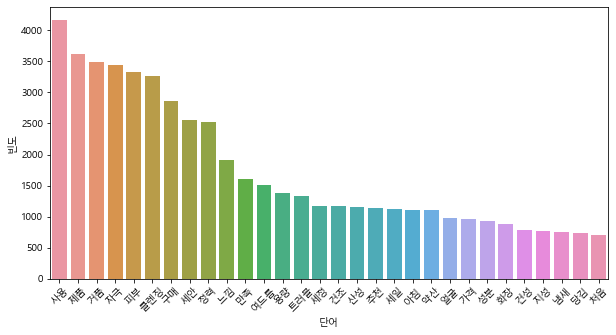

In [1278]:
#클렌징 단어빈도 그래프
plt.figure(figsize=(10,5))
sns.barplot(x='단어', y='빈도',data=cleansing_word)
plt.xticks(rotation=45)
plt.show()

In [917]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

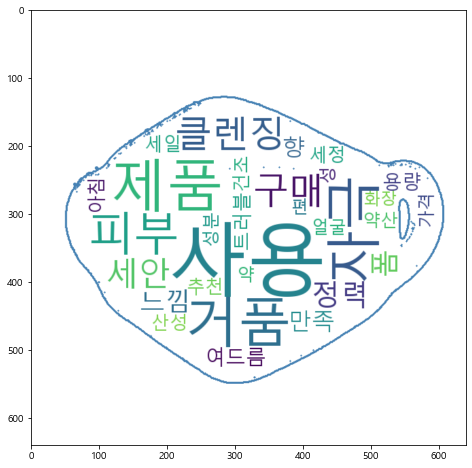

In [939]:
#4-3번 코드
plt.figure(figsize=(8,8))
custom_mask = np.array(Image.open("마스크.jpg"))
wc = WordCloud(font_path ='C:/Windows/Fonts/Malgun.ttf',background_color="white", width = 480, height=480, mask=custom_mask,max_words=30,contour_width=3, contour_color='steelblue')
wc.generate_from_frequencies(count_dic)


plt.imshow(wc, interpolation='bilinear')

# 스킨토너 단어빈도 + 클라우드

In [1181]:
#스킨토너 전체 단어 빈도(키위)
word_count = pd.DataFrame({
    '단어': words,
    '빈도': tdm.sum(axis=0).flat
})

word_sort=word_count.sort_values('빈도',ascending=False).head(30)
word_sort['단어']=word_sort.단어.str.split('/').str.get(0)
new_skin=word_sort

In [1276]:
new_skin

,단어,빈도
708,사용,9349.898158
1862,피부,8054.133732
1434,제품,6445.626166
132,구매,6225.075807
1327,자극,5920.805143
1729,토너,5384.538578
269,느낌,3811.141870
848,스킨,3785.893386
1189,용량,3747.732351
615,보습,3360.193779


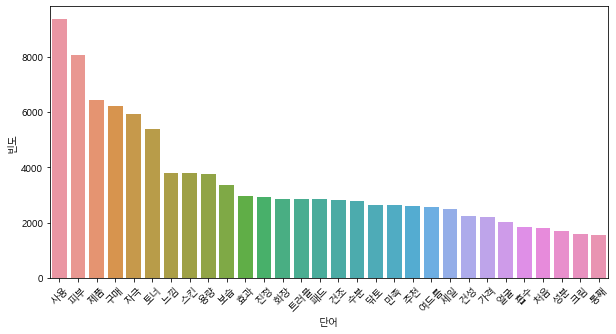

In [1185]:
#스킨 단어빈도 그래프
plt.figure(figsize=(10,5))
sns.barplot(x='단어', y='빈도',data=new_skin)
plt.xticks(rotation=45)
plt.show()

In [1186]:
skin_dic=new_skin.set_index('단어')['빈도'].to_dict()

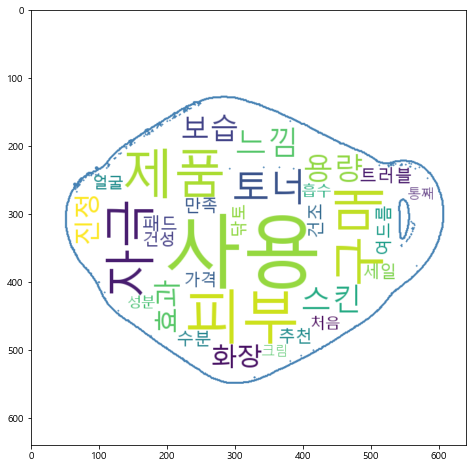

In [1187]:
plt.figure(figsize=(8,8))
custom_mask = np.array(Image.open("마스크.jpg"))
wc = WordCloud(font_path ='C:/Windows/Fonts/Malgun.ttf',background_color="white", width = 480, height=480, mask=custom_mask,max_words=30,contour_width=3, contour_color='steelblue')
wc.generate_from_frequencies(skin_dic)


plt.imshow(wc, interpolation='bilinear')

In [1183]:
#extract_keywords사용 1글자짤 ㅣ단어도 중요한 것이 있기 때문 (향, 솜)
skin_toner_word

,단어,빈도
749,사용,8425.929253
1862,피부,7226.779867
1446,제품,5878.668514
123,구매,5655.053403
1356,자극,5289.186234
1733,토너,4817.474644
265,느낌,3410.761922
1219,용량,3383.116962
882,스킨,3366.106129
1921,향,3095.768874


# 로션 단어빈도 + 클라우드

In [1267]:
#로션 전체 단어 빈도(tokenizer)
word_count = pd.DataFrame({
    '단어': words,
    '빈도': tdm.sum(axis=0).flat
})

word_sort=word_count.sort_values('빈도',ascending=False).head(30)
word_sort['단어']=word_sort.단어.str.split('/').str.get(0)
cream_word2=word_sort

In [1268]:
cream_word2

,단어,빈도
928,피부,1592.455673
365,사용,1500.929941
741,제품,1328.126895
210,로션,1323.133888
57,구매,1164.931829
691,자극,1144.294087
315,보습,1142.018844
28,건조,736.508999
859,크림,684.190905
27,건성,658.612281


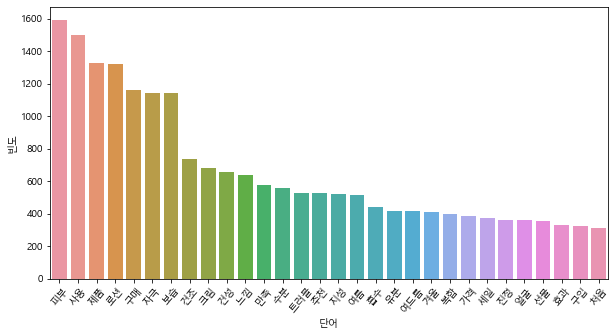

In [1289]:
#로션 단어빈도 그래프
plt.figure(figsize=(10,5))
sns.barplot(x='단어', y='빈도',data=cream_word2)
plt.xticks(rotation=50)
plt.show()

In [1279]:
cream_dic=cream_word2.set_index('단어')['빈도'].to_dict()

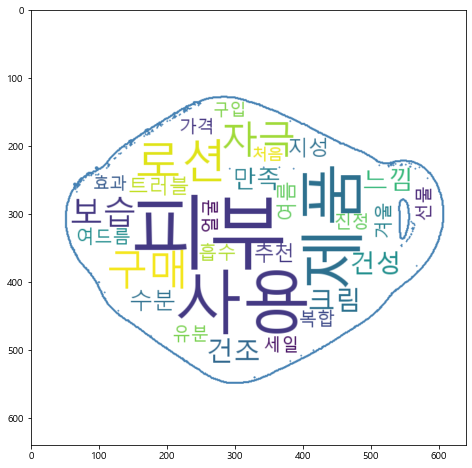

In [1280]:
plt.figure(figsize=(8,8))
custom_mask = np.array(Image.open("마스크.jpg"))
wc = WordCloud(font_path ='C:/Windows/Fonts/Malgun.ttf',background_color="white", width = 480, height=480, mask=custom_mask,max_words=30,contour_width=3, contour_color='steelblue')
wc.generate_from_frequencies(cream_dic)


plt.imshow(wc, interpolation='bilinear')

In [1281]:
#extract_keywords사용 1글자짤 ㅣ단어도 중요한 것이 있기 때문 (향, 솜)
cream_word

,단어,빈도
515,사용,1102.205854
1204,피부,1032.587036
970,제품,932.338692
305,로션,904.419699
94,구매,861.750697
59,것,670.658894
449,보습,650.086697
1074,촉촉,641.980445
56,건조,539.850464
1268,향,537.582546


# 여기서부턴 감정분석 5번코드

In [95]:
#전체데이터 감정분석 (x) 긍정 비율이 너무많음 
x=tdm
y=clean_df.label.values

In [1411]:
#random긍부정 7:3 비율 감정분석 
x=tdm
y=gamjung.label.values

In [1412]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1984)

In [1413]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [1414]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#sgd 경사하강법 -> 변형형태 adam, 손실함수 교차 앤트로피 0,1로 분류하는,   

In [435]:
#0.7127(클렌징폼 감정분석) #이미 데이터를 섞어놔서 정확도가 그렇게 증가하지는 않음
model.fit(x_train.A,y_train,epochs=100,validation_split=0.1,
         callbacks=[tf.keras.callbacks.EarlyStopping()])#10퍼센트 데이터
#중요시하는 지표를 기준으로 학습을 멈추게함.

Epoch 1/100
227/227 [==============================] - 1s 1ms/step - loss: 0.6800 - accuracy: 0.5980 - val_loss: 0.6375 - val_accuracy: 0.7127
Epoch 2/100
227/227 [==============================] - 0s 925us/step - loss: 0.6337 - accuracy: 0.7003 - val_loss: 0.6163 - val_accuracy: 0.7127
Epoch 3/100
227/227 [==============================] - 0s 1ms/step - loss: 0.6201 - accuracy: 0.6941 - val_loss: 0.6085 - val_accuracy: 0.7127
Epoch 4/100
227/227 [==============================] - 0s 934us/step - loss: 0.6172 - accuracy: 0.6900 - val_loss: 0.6052 - val_accuracy: 0.7127
Epoch 5/100
227/227 [==============================] - 0s 894us/step - loss: 0.6145 - accuracy: 0.6908 - val_loss: 0.6037 - val_accuracy: 0.7127
Epoch 6/100
227/227 [==============================] - 0s 832us/step - loss: 0.6085 - accuracy: 0.6953 - val_loss: 0.6030 - val_accuracy: 0.7127
Epoch 7/100
227/227 [==============================] - 0s 810us/step - loss: 0.6084 - accuracy: 0.6951 - val_loss: 0.6024 - val_accura

In [1216]:
#0.7150(스킨/토너 감정분석) 
model.fit(x_train.A,y_train,epochs=100,validation_split=0.1,
         callbacks=[tf.keras.callbacks.EarlyStopping()])#10퍼센트 데이터
#중요시하는 지표를 기준으로 학습을 멈추게함.

Epoch 1/100
450/450 [==============================] - ETA: 2:25 - loss: 0.6977 - accuracy: 0.43 - ETA: 0s - loss: 0.6878 - accuracy: 0.5628 - ETA: 0s - loss: 0.6819 - accuracy: 0.60 - ETA: 0s - loss: 0.6769 - accuracy: 0.62 - ETA: 0s - loss: 0.6729 - accuracy: 0.64 - ETA: 0s - loss: 0.6690 - accuracy: 0.64 - 1s 1ms/step - loss: 0.6658 - accuracy: 0.6549 - val_loss: 0.6134 - val_accuracy: 0.7150
Epoch 2/100
450/450 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.68 - ETA: 0s - loss: 0.6252 - accuracy: 0.68 - ETA: 0s - loss: 0.6187 - accuracy: 0.69 - ETA: 0s - loss: 0.6167 - accuracy: 0.70 - ETA: 0s - loss: 0.6159 - accuracy: 0.70 - ETA: 0s - loss: 0.6155 - accuracy: 0.70 - 0s 771us/step - loss: 0.6152 - accuracy: 0.7009 - val_loss: 0.6023 - val_accuracy: 0.7150
Epoch 3/100
450/450 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.75 - ETA: 0s - loss: 0.6023 - accuracy: 0.70 - ETA: 0s - loss: 0.6021 - accuracy: 0.70 - ETA: 0s - loss: 0.6031 

In [1415]:
#0.7368(로션 감정분석)
model.fit(x_train.A,y_train,epochs=100,validation_split=0.1,
         callbacks=[tf.keras.callbacks.EarlyStopping()])#10퍼센트 데이터
#중요시하는 지표를 기준으로 학습을 멈추게함.

Epoch 1/100
102/102 [==============================] - ETA: 29s - loss: 0.6887 - accuracy: 0.593 - ETA: 0s - loss: 0.6869 - accuracy: 0.589 - 1s 2ms/step - loss: 0.6846 - accuracy: 0.6026 - val_loss: 0.6580 - val_accuracy: 0.7341
Epoch 2/100
102/102 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.59 - ETA: 0s - loss: 0.6561 - accuracy: 0.70 - 0s 1ms/step - loss: 0.6553 - accuracy: 0.7064 - val_loss: 0.6328 - val_accuracy: 0.7368
Epoch 3/100
102/102 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.71 - ETA: 0s - loss: 0.6391 - accuracy: 0.70 - 0s 1ms/step - loss: 0.6384 - accuracy: 0.7015 - val_loss: 0.6159 - val_accuracy: 0.7368
Epoch 4/100
102/102 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.56 - ETA: 0s - loss: 0.6283 - accuracy: 0.69 - 0s 1ms/step - loss: 0.6277 - accuracy: 0.6962 - val_loss: 0.6040 - val_accuracy: 0.7368
Epoch 5/100
102/102 [==============================] - ETA: 0s - loss: 0.6615 - accuracy:

In [1416]:
w,b=model.weights #w 가 단어별 가중치 w가 그단어가 많이 나올수록 문서가 긍정적 부정적`

In [1417]:
word_sent=pd.DataFrame({'토큰':words,'가중치':w.numpy().flat}) #한줄로 들어가게 형태를 바꿔줌



# 클렌징폼 감정분석

In [824]:
#5-1번 코드 절대값
cleansing_bad2=word_sent.sort_values('가중치').head(30)
cleansing_bad2['가중치']=abs(cleansing_bad2['가중치'])

In [825]:
#5-1번 코드 정렬
cleansing_good2=word_sent.sort_values('가중치').tail(30)
cleansing_good2=cleansing_good2.sort_values(by='가중치',ascending=False)

In [841]:
cleansing_bad2

,토큰,가중치
592,화학,0.596491
57,기름기,0.545767
344,얼마,0.519861
429,작년,0.478770
288,시국,0.469334
411,이틀,0.445891
329,알로에,0.427090
543,패드,0.416472
285,스킨케어,0.404544
128,레몬,0.392098


In [1237]:
cleansing_good2

,토큰,가중치
242,샀어,0.808139
348,여기,0.757870
307,아기,0.747925
545,퍼펙트,0.644138
481,쫀득,0.590634
105,대체,0.569115
289,시기,0.565829
99,당장,0.551392
380,워터,0.541277
45,구성,0.531311


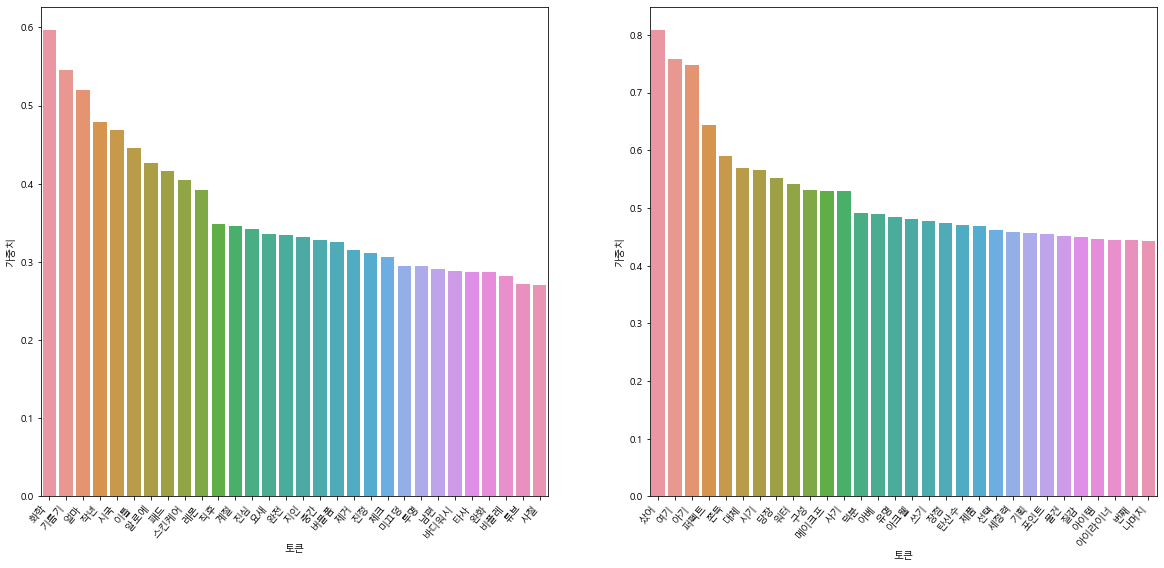

In [865]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
fig.autofmt_xdate(rotation=50)
sns.barplot(x='토큰', y='가중치',data=cleansing_bad2,ax=ax1)
sns.barplot(x='토큰', y='가중치',data=cleansing_good2,ax=ax2)

plt.show()

# 스킨 / 토너 감정분석

In [1223]:
#스킨/토너 감정분석 (부정)
skin_bad=word_sent.sort_values('가중치').head(30)
skin_bad['가중치']=abs(skin_bad['가중치'])

In [1234]:
skin_bad

,토큰,가중치
210,무리,0.374079
208,모양,0.373747
285,비욘드,0.365661
648,찹찹,0.336988
232,바람,0.335444
350,수렴,0.312696
100,누구,0.312400
609,주문,0.308985
478,온도,0.301176
207,모두,0.288243


In [1226]:
skin_good=word_sent.sort_values('가중치').tail(30)
skin_good=skin_good.sort_values(by='가중치',ascending=False)

In [1236]:
skin_good

,토큰,가중치
198,머리,0.623418
566,저거,0.580241
51,광고,0.554623
10,감도,0.530182
220,물토너,0.514233
311,샀어,0.485584
195,말씀,0.483777
568,저녁,0.473376
90,남동생,0.457467
5,가요,0.453934


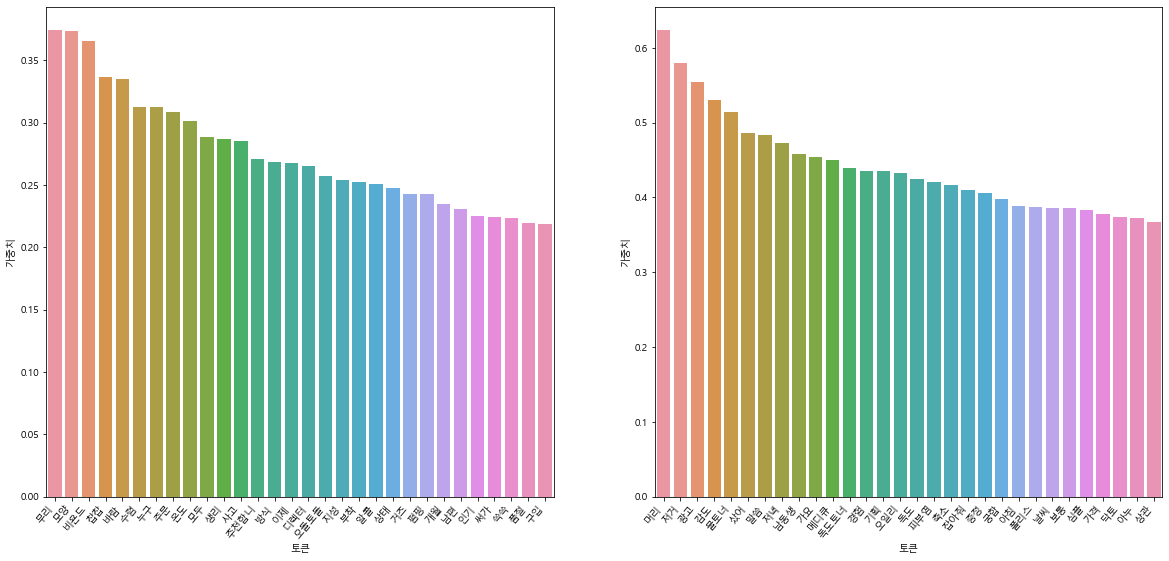

In [1227]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
fig.autofmt_xdate(rotation=50)
sns.barplot(x='토큰', y='가중치',data=skin_bad,ax=ax1)
sns.barplot(x='토큰', y='가중치',data=skin_good,ax=ax2)

plt.show()

# 로션 감정분석

In [1422]:
#로션 감정분석(부정)
cream_bad=word_sent.sort_values('가중치').head(30)
cream_bad['가중치']=abs(cream_bad['가중치'])

In [1423]:
cream_bad

,토큰,가중치
87,대비,0.523412
50,기본,0.438024
426,쿠폰,0.437770
373,조카,0.390155
360,전체,0.375571
337,인생템,0.365960
338,인원,0.360669
190,상태,0.354207
383,주변,0.346271
31,관리,0.344314


In [1421]:
#로션 감정분석(긍정)
cream_good=word_sent.sort_values('가중치').tail(30)
cream_good=cream_good.sort_values(by='가중치',ascending=False)

In [1424]:
cream_good

,토큰,가중치
30,공급,0.570006
24,겨울철,0.555933
82,단점,0.555200
388,중요,0.550797
294,오후,0.533082
101,딸아이,0.532056
284,예전,0.525669
249,아침,0.509678
468,피부과,0.504583
153,병원,0.488225


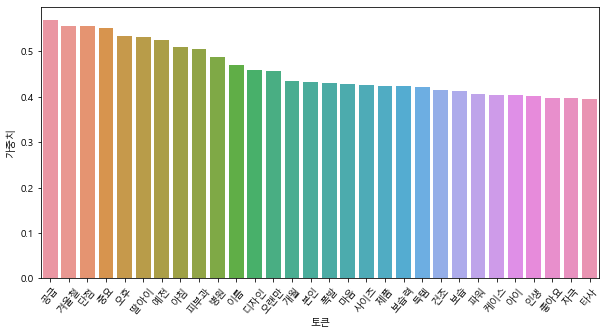

In [1429]:
fig=plt.figure(figsize=(10,5))
sns.barplot(x='토큰', y='가중치',data=cream_good)
plt.xticks(rotation=50)
plt.show()

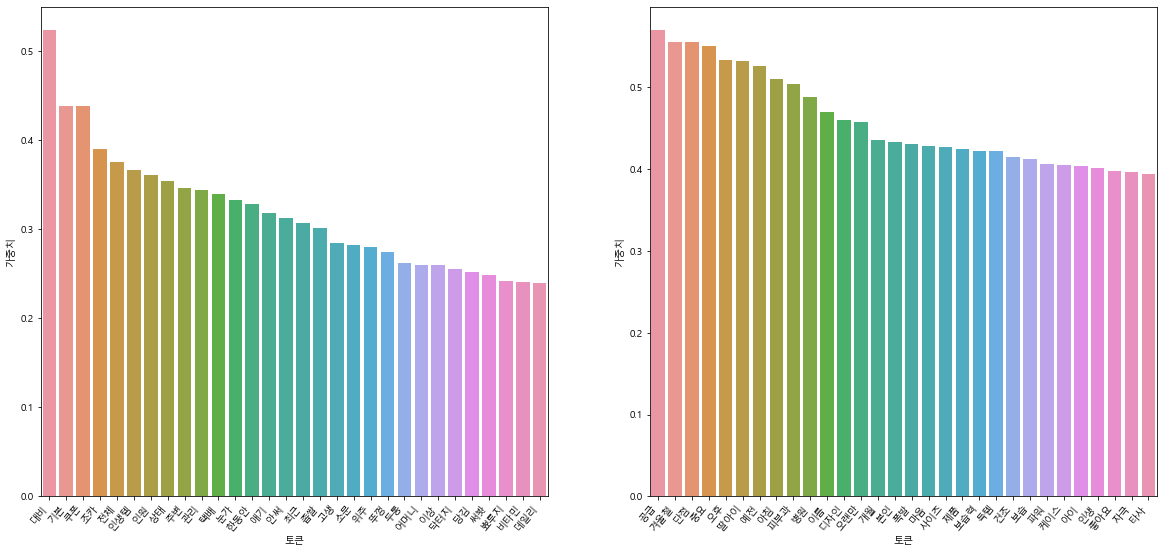

In [1426]:
fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
fig.autofmt_xdate(rotation=50)
sns.barplot(x='토큰', y='가중치',data=cream_bad,ax=ax1)
sns.barplot(x='토큰', y='가중치',data=cream_good,ax=ax2)

plt.show()

# 주제분석 토픽 단어 숫자 정하기(차원) 6번코드

In [1031]:
from gensim.models import CoherenceModel
from gensim import corpora, models
import gensim

In [1286]:
coherences=[]
perplexities=[]
dayang=[]
warnings.filterwarnings('ignore')

for i in range(2,50,3):
    lda4 = LdaModel(corpus, id2word=dic, num_topics=i)
    print('토픽 갯수 : {}개'.format(i))
    # tfidf, corpus 무슨 차이?
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=lda4, corpus=corpus,texts=docs,dictionary=dic,coherence='c_v')
    coherence = cm.get_coherence()
    print("Coherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus))
    perplexities.append(lda4.log_perplexity(corpus))
    topn=25
    top_words=set()
    for topic in range(lda4.num_topics):
        for word, prob in lda4.show_topic(topic,topn=topn):
            top_words.add(word)
    summary=len(top_words)/(25*i)
    dayang.append(summary)
    print("주제 다양도:",summary,'\n\n')
    

토픽 갯수 : 2개
Coherence 0.5199129333368471
Perplexity:  -5.365925814289273
주제 다양도: 0.82 


토픽 갯수 : 5개
Coherence 0.5266221956765762
Perplexity:  -5.503372955210559
주제 다양도: 0.576 


토픽 갯수 : 8개
Coherence 0.4941302498256574
Perplexity:  -5.573407405855822
주제 다양도: 0.525 


토픽 갯수 : 11개
Coherence 0.5321424584297119
Perplexity:  -5.631634524855198
주제 다양도: 0.5381818181818182 


토픽 갯수 : 14개
Coherence 0.527782567155764
Perplexity:  -6.145908271409978
주제 다양도: 0.52 


토픽 갯수 : 17개
Coherence 0.4945811309940256
Perplexity:  -6.474410410019012
주제 다양도: 0.5341176470588235 


토픽 갯수 : 20개
Coherence 0.4977216316336717
Perplexity:  -6.605495601585591
주제 다양도: 0.554 


토픽 갯수 : 23개
Coherence 0.47807627502850336
Perplexity:  -6.778911875005003
주제 다양도: 0.5617391304347826 


토픽 갯수 : 26개
Coherence 0.482986196290223
Perplexity:  -6.9526890268627595
주제 다양도: 0.5107692307692308 


토픽 갯수 : 29개
Coherence 0.4463514257241053
Perplexity:  -7.153089526030985
주제 다양도: 0.5310344827586206 


토픽 갯수 : 32개
Coherence 0.4525803902885032

# 클렌징폼 최적 토픽 수 찾기 

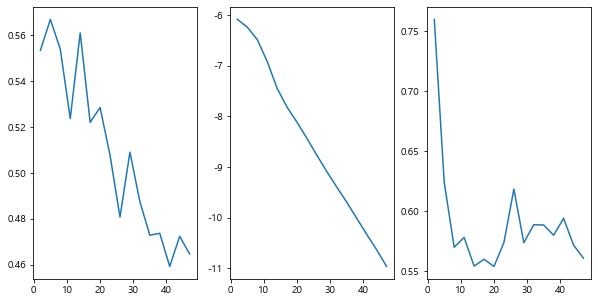

In [1134]:
#6-3번 코드 토픽갯수 14가 최적값
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)
x=range(2,50,3)
ax1.plot(x,coherences)
ax2.plot(x,perplexities)
ax3.plot(x,dayang)

plt.show()

# 스킨/토너 최적 토픽 수 찾기

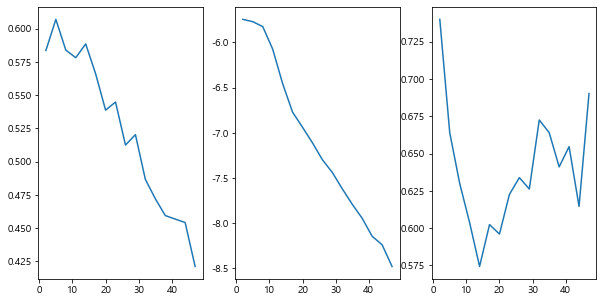

In [1245]:
#토픽갯수 17이 최적값
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)
x=range(2,50,3)
ax1.plot(x,coherences)
ax2.plot(x,perplexities)
ax3.plot(x,dayang)

plt.show()

# 로션 최적 토픽 수 찾기

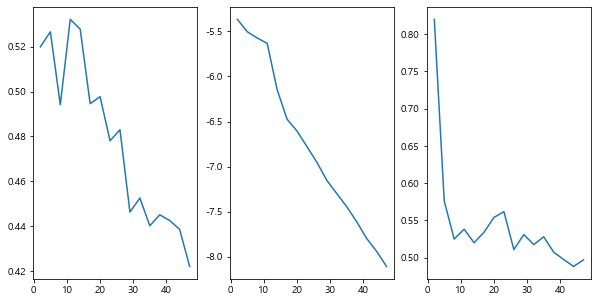

In [1287]:
#토픽갯수 14이 최적값
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)
x=range(2,50,3)
ax1.plot(x,coherences)
ax2.plot(x,perplexities)
ax3.plot(x,dayang)

plt.show()

# 최적 차원의수 찾기 6-1번 코드

In [1055]:
svd=TruncatedSVD(n_components=100, random_state=1234) #차원의수 100으로 지정
svd.fit(tdm2)

TruncatedSVD(n_components=100, random_state=1234)

In [1063]:
svd.components_.shape #100행의 차원 2000개 단어와 어떤 관계가있는지

(100, 1400)

In [1064]:
nrow,ncol=tdm2.shape

In [1067]:
def resample(a):
    return np.random.choice(a,size=nrow) #단어의 분포와똑같은 분포를 가진 어떠한 데이터를 가질수 있다?
np.random.seed(2999)
d= np.apply_along_axis(resample,0,tdm2.A)#각 열마다 마구잡이로 뽑아서 새 x를 만듬 단어 빈도의 분포는 비슷, 단어들과의 관계를 망가뜨린것


In [1068]:
svd2=TruncatedSVD(n_components=100,random_state=1234)
svd2.fit(d)

TruncatedSVD(n_components=100, random_state=1234)

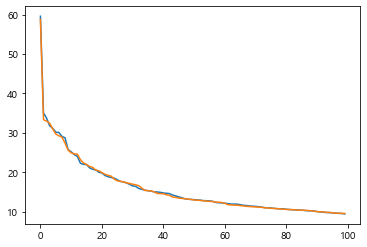

In [1070]:
plt.plot(svd.singular_values_) #100개차원으로 줄였는데 각각 차원의 갖는 중요성 이라고 알아둬라
plt.plot(svd2.singular_values_)
#앞부분에 있는 차원이 뭔가를 더설명하는 부분이 많다. 주황색은 마구잡이로 섞어서 한거기 떄문에 차원들이 설명하는 부분이 적다. 
#차원들이 뒤쪽의 차원들은 별로큰 의마가 없다. 

In [1071]:
#6-2번코드
svd.singular_values_-svd2.singular_values_#실제데이터가 영향력있다가 마이너스 되는 부분이 가짜데이터랑 별차이 없는 부분

array([ 8.76320283e-01,  1.72729937e+00,  7.38205961e-01, -6.38438354e-01,
        1.63739261e-01,  4.65193099e-01,  8.56376992e-01,  1.71608046e-01,
        1.35033424e+00,  1.31807648e-01,  2.78464889e-01, -1.85622664e-01,
       -5.64993722e-01, -9.24698799e-01, -3.71011545e-01, -1.11170309e-02,
       -3.35598989e-01, -4.87343899e-01,  3.43553402e-02, -3.83683895e-01,
       -1.03122263e-01, -2.99429712e-01, -3.61779081e-01, -3.35194515e-01,
        2.39775491e-01,  2.67082984e-01, -1.91121549e-02, -3.42707855e-02,
       -2.28454860e-02, -2.23577514e-01, -4.31319098e-01, -3.96167747e-01,
       -7.06765969e-01, -3.11838479e-01,  7.19184340e-02, -1.93803794e-02,
       -3.75745077e-02, -4.00521921e-03,  3.79822254e-01,  3.24980586e-01,
        2.18709632e-01,  3.85036043e-01,  4.61573142e-01,  4.93543667e-01,
        3.97168520e-01,  2.96842476e-01,  1.85141516e-01, -4.39269823e-02,
       -3.59279603e-02,  1.34587647e-02,  7.89474853e-02,  8.18325390e-02,
        6.65566380e-02,  

In [1072]:
np.argwhere(svd.singular_values_-svd2.singular_values_<=0)[0] #필요한 차원은 89차원까지만 필요하다.
#89로 바꿔서 돌리거나 89차원 이후로 무시. 만약 따라잡히는 구간이 없다면 차원을 늘려서 다시돌린다.

array([3], dtype=int64)

# 주제분석 과정

In [1282]:
docs = []
for text in clean_df.리뷰:
    doc = tokenizer(text)
    docs.append(doc)

In [1283]:
dic = Dictionary(docs)

In [1284]:
dic.filter_extremes(no_below=10,no_above=1)#엔 모스트 프리퀀트는 가장 자주 나오는 단어 기준으로, 익스트림은 극단적인단어, no_beolow = 일부 문서에서 사용된걸 제외 no_above= 너무 흔하게 나온 단어들은 제외 
                                            #10개이하의 문서 자르고 90퍼센트 이상의 문서에서 나오는것 잘라내기

In [1285]:
corpus=[]
for doc in docs:
    bow=dic.doc2bow(doc) #bag of words
    corpus.append(bow)

In [1430]:
train_corpus, valid_corpus = train_test_split(corpus, test_size=0.1, random_state=5432)

In [1155]:
#LDA에 어떤 경고를 무시
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [1431]:
#6-4번 코드 
model = LdaModel(
    corpus=train_corpus,
    id2word=dic,#번호하고 단어 짝지은것 
    num_topics=11,passes=10,
    random_state=1234)

In [1432]:
loss = model.log_perplexity(valid_corpus)

In [1433]:
loss

-6.06230202397978

In [1250]:
old_loss=-np.inf
while loss > old_loss + 0.1:
    model.update(train_corpus)
    old_loss = loss
    loss = model.log_perplexity(valid_corpus)
    print(loss)

-6.92272422792693


In [1096]:
kk=model.show_topic(0,topn=20)
kk2=pd.DataFrame(kk)

In [1082]:
model.expElogbeta

array([[1.4996759e-03, 2.9472006e-02, 1.8640510e-04, ..., 6.1860055e-13,
        6.1860055e-13, 6.1860055e-13],
       [3.9012835e-03, 6.8989164e-07, 1.1107392e-02, ..., 6.7666071e-13,
        6.7647488e-13, 6.7647488e-13],
       [1.1164229e-03, 1.3790411e-11, 3.2344859e-02, ..., 7.3528336e-13,
        7.3528336e-13, 7.3528336e-13],
       ...,
       [4.3338191e-04, 2.0934582e-11, 3.6483384e-03, ..., 5.2249904e-13,
        5.2239143e-13, 5.2244721e-13],
       [2.1722602e-02, 2.0968176e-03, 1.4058115e-02, ..., 1.7472074e-13,
        1.7476473e-13, 1.7472074e-13],
       [1.0974662e-04, 4.9877463e-13, 2.5375924e-01, ..., 4.8200186e-13,
        4.8195405e-13, 4.8183641e-13]], dtype=float32)

In [1083]:
from sklearn.decomposition import PCA
topic_vector = model.expElogbeta
y = PCA(n_components=2).fit_transform(topic_vector)

print('{} -> {}'.format(topic_vector.shape, y.shape))
# (n_topics, n_terms) -> (n_topics, 2)

(17, 22825) -> (17, 2)


In [1077]:
pyLDAvis.enable_notebook()

In [1078]:
p = pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=False)

# 클렌징폼 pyLDAvis

In [ ]:
#클렌징폼
s=pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=True)

In [1164]:
pyLDAvis.display(s)#토픽 번호가 하나씩 밀려있음 클릭해서 보면 관련된, 0으로지정해서보면 탑 30 샐리언트
#슬라이드 투 어드저스트 메트릭스 어떤 토픽하고 어떤단어가 관련된 정도를 계산할때 두가지 지표 사용 
# 1이 끝으로 가있으면 그 토픽에서 가장 많이나오는 단어 기준으로 계산한것  절대적
# 0으로 하면 평소에 그 단어가 나오는 비율대비해서 이토픽에선 얼마나 자주나오나 계산 상대적
# 보통 0.6정도 권장

# 스킨 / 토너 pyLDAvis

In [1251]:
t=pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=True)

In [1252]:
pyLDAvis.display(t)

# 로션 pyLDAvis

In [1434]:
c=pyLDAvis.gensim.prepare(model, corpus, dic, sort_topics=True)

In [1435]:
pyLDAvis.display(c)

In [ ]:
#초기코드
tag=[]
text =[]
star = []

start = time.time()

for url in urls: 
    print('상품코드',url.split('?')[1].split('&')[0].split('=')[1],'수집 시작합니다.')
    
    browser=Chrome()
    browser.get(url)
    time.sleep(2)
    browser.find_element_by_xpath('//*[@id="reviewInfo"]/a').click()
    time.sleep(2)
    
    for click in range(1,11):
        cnt = 0    
        if click == 1:   ### 1페이지는 누르지 않아도 되기 때문에 pass
            
            for tg in range(0,10):
                try:
                    cv=browser.find_elements_by_css_selector('.user.clrfix')[tg]
                    hi=cv.find_elements_by_css_selector('.tag')[0]
                    tag.append(hi.text)
                except IndexError as error:
                    tag.append("")


            for re in browser.find_elements_by_css_selector('.txt_inner'):
                text.append(re.text)

            for st in browser.find_elements_by_css_selector('.point'):
                if cnt==0:
                    pass
                else:
                    star.append(st.text)
                cnt += 1
        
        else:    ### 이후 페이지는 각 버튼을 눌러 리뷰페이지 update            
            page=browser.find_elements_by_css_selector("div.pageing > a:nth-child({})".format(click))
            page[0].click()
            time.sleep(2)
            for tg in range(10):
                try:
                    cv=browser.find_elements_by_css_selector('.user.clrfix')[tg]
                    hi=cv.find_elements_by_css_selector('.tag')[0]
                    tag.append(hi.text)
                except IndexError as error:
                    tag.append("")
            for re in browser.find_elements_by_css_selector('.txt_inner'):

                text.append(re.text)

            for st in browser.find_elements_by_css_selector('.point'):
                if cnt==0:
                    pass
                else:
                    star.append(st.text)
                cnt += 1
            
    print('상품코드',url.split('?')[1].split('&')[0].split('=')[1], '수집 완료했습니다!')
    print('소요시간:',round(time.time()-start),'초')
    print('리뷰갯수:',len(text),"개")
    print('—————————————————————')
    break